# HR Analytics - Evaluation

Objective: Create a logistic Reg Model to predict the attrition of employees by using the features available from the datasets given

Created By: Stephen Cole

Creation Date: 25/07/2022

##### Last Updated

In [1]:
from datetime import datetime, timedelta

input("Last Updated By: ")
print(f"Last Updated: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

Last Updated By: Stephen Cole
Last Updated: 12/08/2022 17:34:20


### Import Packages

In [2]:
# Importing all packages in one cell helps to keep the notebook clean and readable as having multiple imports scattered makes
# it hard to keep track of all the packages being used

import pandas as pd
import numpy as np
import os 
import pickle 
import random
import time
import shap

from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix, f1_score, classification_report, mean_squared_error, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

import xgboost as xgb

path_to_data = 'C:\\Users\\coles2\\Documents\\Xander\\Data_Science_Project_HR_Analytics-main\\Datasets'

In [3]:
pd.set_option("display.max_columns", None, "display.max_rows", 500)

### Define Custom Functions

This is where I normally store any functions I use to keep notebooks clean

In [4]:
def save_obj(obj, name, file_path):
    """
    This function saves any object as a .pkl file so that it can be easily read in other notebooks
    
    Parameters
    -----
    obj : Object's variable name 
        The object that needs to be saved.
    name : String
        The name that you would like to save the object as.
    file_path: String
        Directory in which you are saving the object to.
    
    Returns
    -----
        A saved .pkl file in dir and name specified.
    """
    file_path = os.path.join(file_path, name)
    with open(file_path + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name, file_path):
    """
    This function loads any .pkl file
    
    Parameters
    -----
    name : String
        The name of the file that needs to be loaded.
    file_path: String
        Directory in which you are loading the object from.
    
    Returns
    -----
        An object that was saved as a .pkl file in dir and name specified.
    """
    file_path = os.path.join(file_path, name)
    with open(file_path + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def calculate_performance(X_test, y_test, model, model_type, thr=0.5, average='weighted'):
    """
    Calculates model performance
    """
    performance = {}
    dtest = xgb.DMatrix(X_test, label = y_test)
    y_pred_prob = model.predict(dtest)
    if model_type=='binaryclass':
        performance['acc_score'] = accuracy_score(y_test, y_pred_prob > thr)
        performance['prec_score'] = precision_score(y_test, y_pred_prob > thr)
        performance['rec_score'] = recall_score(y_test, y_pred_prob > thr)
        performance['roc_auc'] = roc_auc_score(y_test, y_pred_prob)
        performance['F1_score'] = f1_score(y_test, y_pred_prob > thr)
        print(classification_report(y_test, y_pred_prob>thr,digits=4))
        
    if model_type=='multiclass':
        y_pred=y_pred_prob.argmax(axis=1)
        performance['acc_score'] = accuracy_score(y_test, y_pred)#,average =average)
        performance['prec_score'] = precision_score(y_test, y_pred,average =average)
        performance['rec_score'] = recall_score(y_test, y_pred,average =average)
        performance['roc_auc'] = roc_auc_score(y_test, y_pred_prob,average =average,multi_class='ovr')

        performance['F1_score'] = f1_score(y_test, y_pred ,average =average)
        print(classification_report(y_test, y_pred,digits=4))
        
    if model_type=='regression':
        y_pred = model.predict(dtest)
        performance['rmse'] = mean_squared_error(y_test, y_pred, squared=False)

    return performance

### Load Objects

In [5]:
start_time = time.time()
print('start_time', time.asctime( time.localtime(time.time()) ))

X = load_obj(name='Modelling_dset', file_path=path_to_data)
y = load_obj(name='Target', file_path=path_to_data)
features = load_obj(name='features', file_path=path_to_data)
model = load_obj(name='HR_Attrition_Model_202207', file_path=path_to_data)

end_time = time.time()
total_time = end_time - start_time
print('total_time to read data', str(timedelta(seconds=total_time)))

start_time Fri Aug 12 17:34:37 2022
total_time to read data 0:00:00.077029


In [6]:
X = X[features]

In [7]:
X.shape

(4410, 27)

In [8]:
print('Features:', features, 'Number of features:', len(features), sep='\n')

Features:
['maritalstatus_Single', 'totalworkingyears', 'businesstravel_Travel_Frequently', 'environmentsatisfaction_Low', 'educationfield_Human Resources', 'yearswithcurrmanager', 'jobsatisfaction_Very High', 'environmentsatisfaction_Very High', 'yearssincelastpromotion', 'educationfield_Life Sciences', 'numcompaniesworked', 'gender_Female', 'jobsatisfaction_Low', 'worklifebalance_Good', 'jobrole_Research Director', 'department_Human Resources', 'education_Below College', 'worklifebalance_Bad', 'environmentsatisfaction_High', 'jobrole_Sales Representative', 'maritalstatus_Divorced', 'worklifebalance_Better', 'distancefromhome', 'trainingtimeslastyear', 'jobsatisfaction_High', 'education_College', 'education_Bachelor']
Number of features:
27


## HPT

### Train-Test Split

In [9]:
# Split dataset into train and test datasets for evaluation
# Set the random_state for the same split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
# Use XGBoost DMatrix for memory efficiency and model training speed

dmat_test = xgb.DMatrix(X_test, label=y_test)

In [11]:
# Make Predictions using the model created

predictions = model.predict(dmat_test)

(array([1.107e+03, 1.000e+01, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 2.000e+02]),
 array([5.50114373e-06, 1.00003995e-01, 2.00002491e-01, 3.00000995e-01,
        3.99999499e-01, 4.99997973e-01, 5.99996507e-01, 6.99994981e-01,
        7.99993455e-01, 8.99991989e-01, 9.99990463e-01], dtype=float32),
 <BarContainer object of 10 artists>)

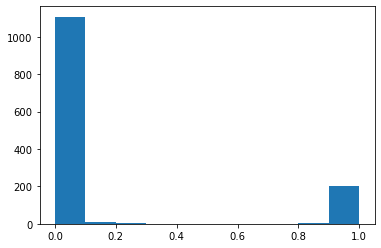

In [12]:
plt.hist(predictions)

In [13]:
performance = calculate_performance(X_test=X, y_test=y, model=model, model_type='binaryclass')

              precision    recall  f1-score   support

           0     0.9957    0.9984    0.9970      3699
           1     0.9914    0.9775    0.9844       711

    accuracy                         0.9950      4410
   macro avg     0.9936    0.9879    0.9907      4410
weighted avg     0.9950    0.9950    0.9950      4410



In [14]:
performance

{'acc_score': 0.9950113378684807,
 'prec_score': 0.9914407988587732,
 'rec_score': 0.9774964838255977,
 'roc_auc': 0.9905014811849022,
 'F1_score': 0.9844192634560907}

Have very promising results but won't be certain until we look at the Gain and Lift Charts. Will also create an ROC curve in case future iterations of the model will be created and can be used to compare the performance of any different iterations.

## Reminder: The stakeholder is interested in the most important features

In [15]:
scores = model.get_score(importance_type='weight')
feature_importances = pd.DataFrame.from_dict(scores, orient='index', columns=['Score'])
results = feature_importances.sort_values(by=['Score'], ascending=False)[:10]
results = results.reset_index()

In [16]:
feature_importances.sort_values(by='Score', ascending=False)

,Score
distancefromhome,561.0
totalworkingyears,441.0
yearswithcurrmanager,307.0
yearssincelastpromotion,265.0
numcompaniesworked,251.0
trainingtimeslastyear,186.0
gender_Female,109.0
educationfield_Life Sciences,102.0
environmentsatisfaction_High,89.0
education_Bachelor,88.0


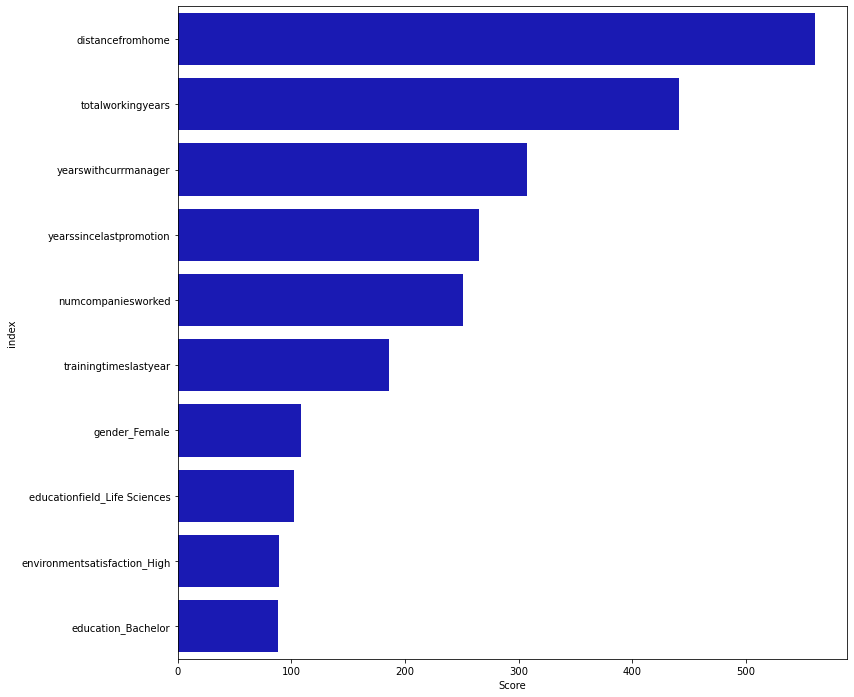

In [17]:
plt.figure(figsize=(12,12))
feature_importance_bar = sns.barplot(x="Score", y='index', data=results,
                                     color="mediumblue")

In [18]:
shap.initjs()

In [19]:
explainer = shap.TreeExplainer(model)

In [20]:
shap_values = explainer.shap_values(X)

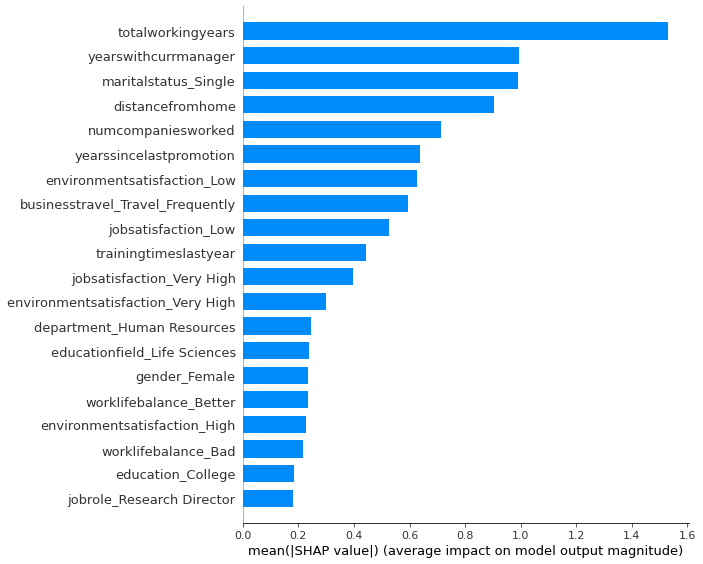

In [21]:
shap.summary_plot(shap_values, X, plot_type='bar', show=False)

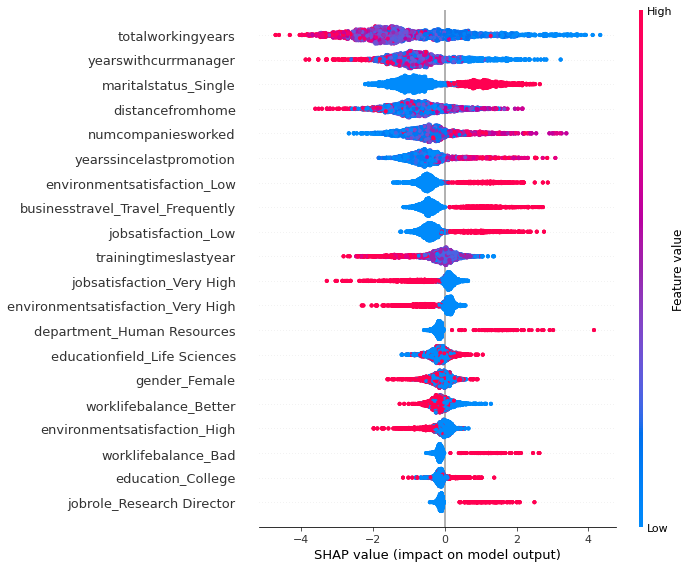

In [22]:
shap.summary_plot(shap_values, X)

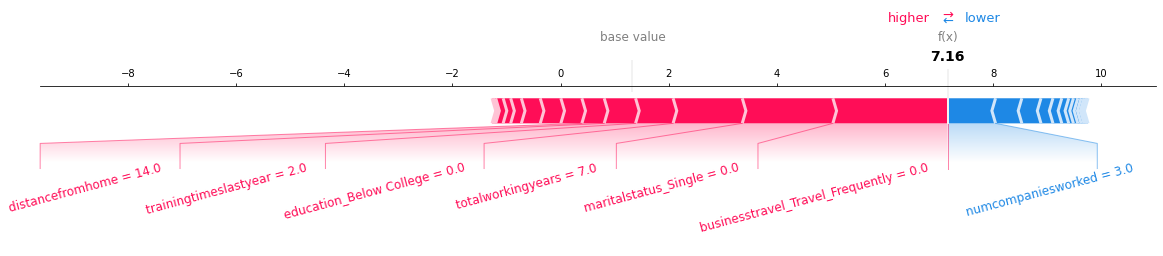

In [23]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[1], features=X_test.iloc[1], text_rotation=(15),
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])

In [24]:
predictions[0]

0.9990101

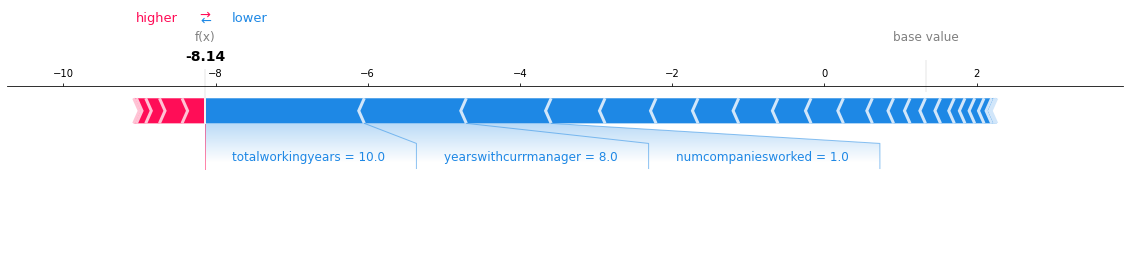

In [25]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[50], features=X_test.iloc[50],
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])

In [26]:
predictions[50]

0.007535493

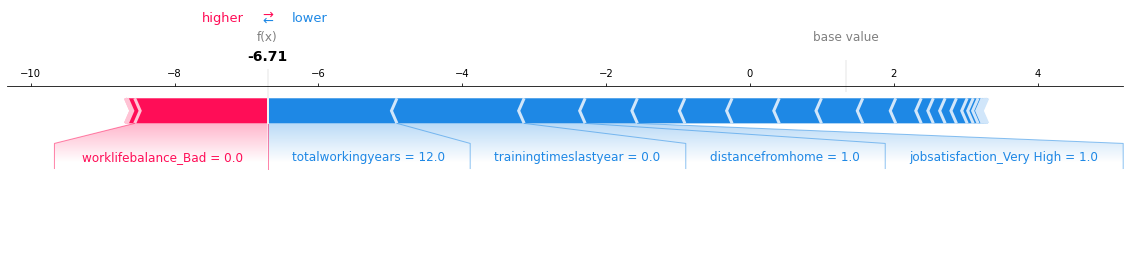

In [27]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[500], features=X_test.iloc[500],
    matplotlib=True, show=True, plot_cmap=['#77dd77', '#f99191'])

In [28]:
predictions[500]

0.002963178

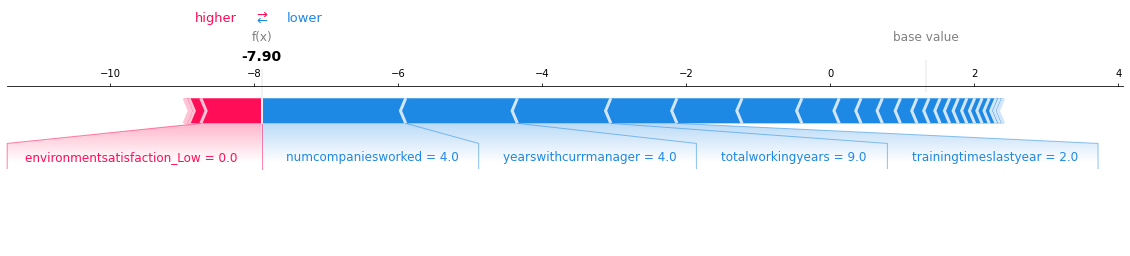

In [29]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[-1], features=X_test.iloc[-1],
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])

In [30]:
predictions[-1]

0.003962575

##### Comments

- ```distancefromhome``` and ```totalworkingyears``` were used the most to split the decision trees within XGBoost, making them important features to deciding who is leaving the company

- ```totalworkingyears``` and ```yearswithcurrmanager``` impacts the model the most. The longer an employee has worked with the company and their current manager, the more likely they are to stay. Therefore it is advised to keep attention to employees who are new to the company or received a new manager.

- Included some force plots to visualise some of the affects of the features for a given employee

Text(74.5, 0.5, 'Actual')

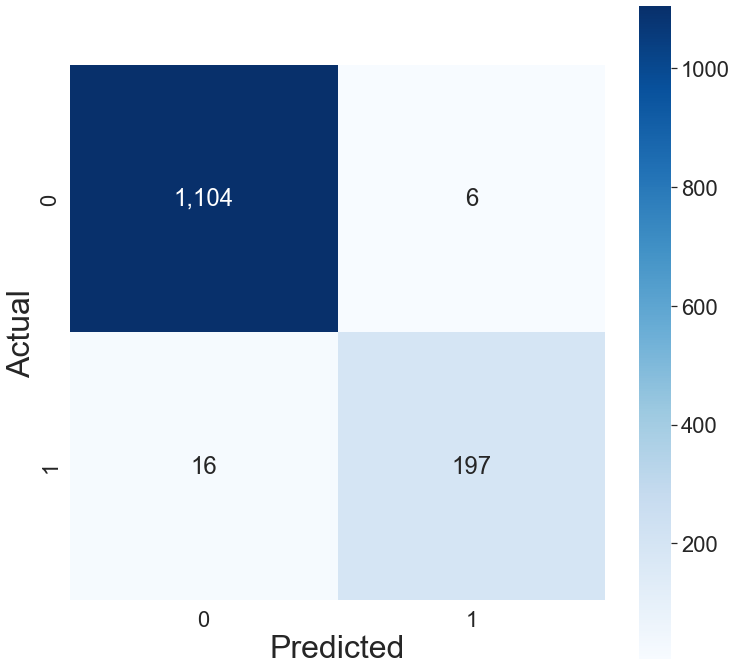

In [31]:
plt.figure(figsize=(12,12))
sns.set_context('talk')
sns.set(font_scale=2)
ax = sns.heatmap(confusion_matrix(y_test, predictions>=0.5),
                 annot_kws = {"size": 24},
                 fmt = ',d',
                 cmap = 'Blues',
                 square = True,
                 xticklabels = ['0', '1'],
                 yticklabels = ['0', '1'],
                 annot=True);
plt.xlabel('Predicted', fontsize=32)
plt.ylabel('Actual', fontsize=32)

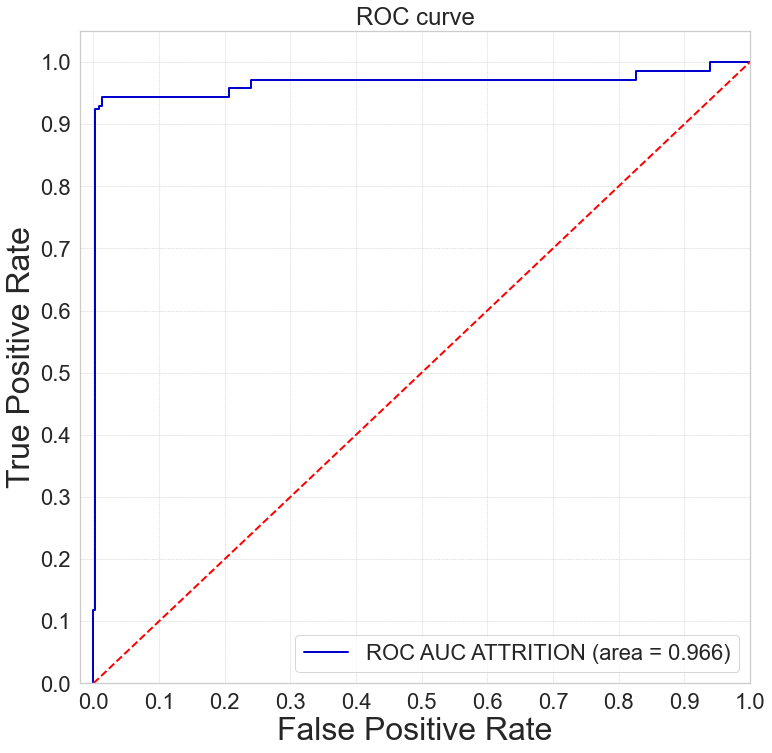

In [32]:
fpr, tpr, _ = roc_curve(y_test, predictions)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr, color='mediumblue', lw=2, label='ROC AUC ATTRITION (area = {0:.3f})'.format(auc(fpr, tpr)))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
plt.xlabel('False Positive Rate', fontsize=32)
plt.ylabel('True Positive Rate', fontsize=32)
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.show()

The curve isnt smooth as we have a very small dataset to test with. Ideally we would use a large dataset that wasnt used for training. But the performance of the model is extremely good.

In [33]:
# Running for uncalibrated model

prob_true, prob_pred = calibration_curve(y_test, predictions, n_bins=5)

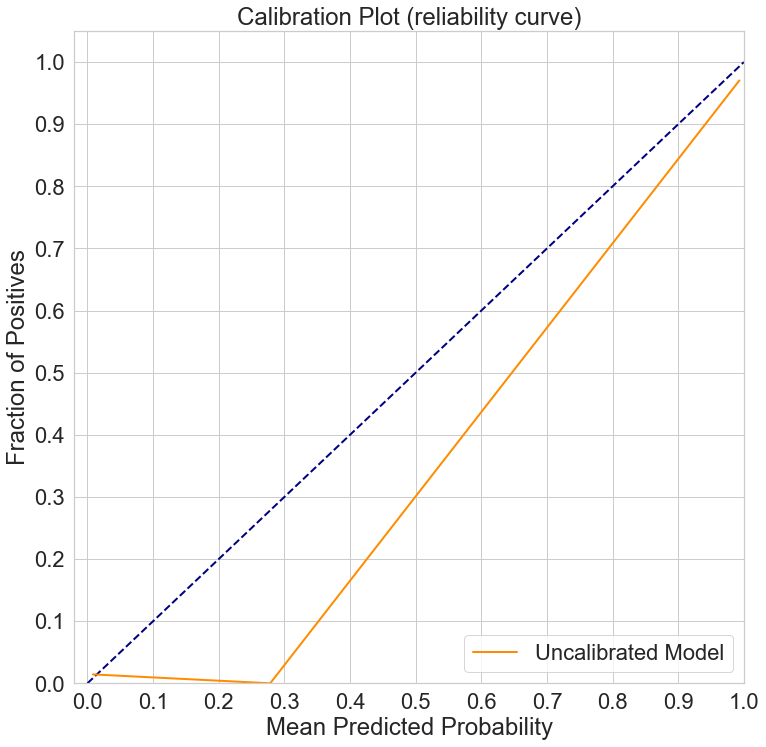

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize = (12,12))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(prob_pred, prob_true, color='darkorange',lw=lw, label='Uncalibrated Model')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot (reliability curve)')
plt.legend(loc="lower right")
plt.show()

## Calibration

Ideally we would also be able to calibrate the dataset. However, we do not have any more un-seen data to do the calibration on. Separating the dataset more would only worsen our model or evaluation so I will leave it out for now. The calibration curve above isn't horrendous either so is fine to leave as is.

## Lift and Gain

In [35]:
y_df = pd.DataFrame(y_test)

In [36]:
lift2 = pd.DataFrame([i for i in zip(predictions,y_df.apply(lambda x: x[0], axis = 1).to_numpy())]).sort_values(0, ascending = False)
lift2['cumpos'] = lift2[1].cumsum()
auc(np.array(range(lift2.shape[0]))/lift2.shape[0],(lift2['cumpos']/max(lift2['cumpos'])).to_numpy())

0.89130905361623

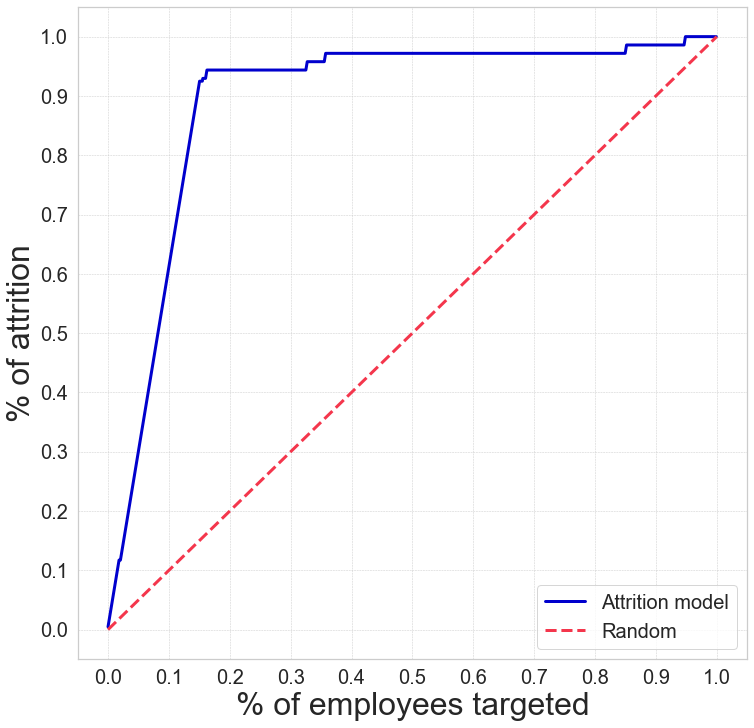

In [37]:
pd.Series((lift2['cumpos']/max(lift2['cumpos'])).to_numpy(), index = np.array(range(lift2.shape[0]))/lift2.shape[0]).plot.line(fontsize = 20, lw = 3, zorder = 3, color = ['mediumblue','#f4364c'], figsize = (12,12))
pd.Series([0,1], index = [0,1]).plot.line(fontsize = 20, lw = 3, zorder = 3, color = ['#f4364c'], linestyle='--', figsize = (12,12))


plt.ylabel('% of attrition', fontsize = 32)
plt.xlabel('% of employees targeted', fontsize = 32)
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.legend(['Attrition model','Random'],fontsize = 20, loc='lower right')
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder = 0)

In [38]:
lift3 = pd.Series((lift2['cumpos']/max(lift2['cumpos'])).to_numpy(), index = np.array(range(lift2.shape[0]))/lift2.shape[0]).div(np.array(range(lift2.shape[0]))/lift2.shape[0])

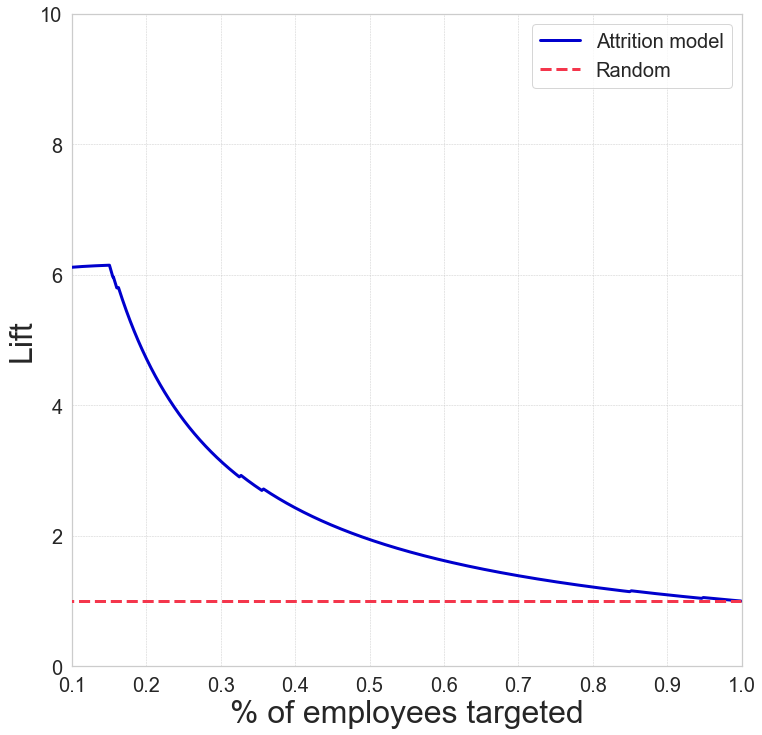

In [39]:
lift3.iloc[1:].plot.line(fontsize = 20, lw = 3, zorder = 3, color = 'mediumblue', figsize = (12,12))

pd.Series([1,1], index = [min(lift3.iloc[1:].index), max(lift3.iloc[1:].index)]).plot.line(fontsize = 20, lw = 3, zorder = 3, color = ['#f4364c'], linestyle='--', figsize=(12,12))
plt.ylabel('Lift', fontsize = 32)
plt.xticks([i/10 for i in range(0,11,1)])
plt.xlabel('% of employees targeted', fontsize = 32);
plt.legend(['Attrition model','Random'],fontsize = 20)
plt.xlim([0.1,1])
plt.ylim([0,10])
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder = 0)

Gain - We can target +90% of employees that attrition by looking at the top 2 deciles of our model's scores

Lift - Able to identify +4x more employees that attrition in comparison to randomly targetting employees when looking at the top 2 deciles as well

# Conclusion

JWC need to encourage employees to work closer to the office, reduce the amount of travelling employees do, invest more into their training, and question those with low job satisfaction to improve their scores. 